In [47]:
import numpy as np
from numpy.random import *

import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
%matplotlib inline

import skimage.transform  

from skimage.transform import resize
from PIL import Image, ImageDraw, ImageFilter  

from perlin_numpy import generate_perlin_noise_2d, generate_fractal_noise_2d

#### make the white circle on the canvas

In [48]:
canvasSize = 450
center = canvasSize//2 #the center point is (canvasSize//2, canvasSize//2)

#hypara
r = 150 #radius of the white circle
scale = 0.5
smoothArea = 0.4
res, octaves, persistence, lacunarity = 3, 5, 0.5, 3
shape = (lacunarity**(octaves - 1)) * res

mask_im = Image.new("L", (canvasSize, canvasSize), 0)
draw = ImageDraw.Draw(mask_im)
draw.ellipse((center-r, center-r, center+r, center+r), fill=255)

In [49]:
def scalingAndBluring(scaledMask, r):
    #scaling & bluring
    for i in range(-1 * r-2, r+2):
        for j in range(-1 * r-2, r+2):
            dist = np.sqrt(i**2 + j**2)
            if dist <= r:            
                length = 1 - dist/r
                if length <= smoothArea:
                    alpha = length / smoothArea
                    scaledMask[center+i][center+j] *= alpha
    return scaledMask    

def calculateMaxPixelValue(Mask): #for debugging
    maxi = 0
    for i in range(len(Mask)):
        m = max(Mask[i])
        maxi = max(maxi, m)
    return maxi

#### make the circle blured and scaled

In [50]:
mask = np.array(mask_im)  
scaledMask = mask*scale

scaledMask = scalingAndBluring(scaledMask, r+1)

#translate np.araray into PIL object
pilScaledMask = Image.fromarray(scaledMask)
pilScaledMask = pilScaledMask.convert("L")

#### apply affine transformation randomly

In [53]:
roi_points = [(0,0),(canvasSize,0),(canvasSize,canvasSize),(0,canvasSize)] 
x1,y1,x2,y2 = (2*r * rand(4) + center-r)
#x1,y1,x2,y2 = (center * rand(4) + center//2)
#x1,y1,x2,y2 = canvasSize * rand(4) 
x1,y1,x2,y2 = int(x1),int(y1),int(x2),int(y2)
from_points = [(x1,y1)]  
to_points = [(x2,y2)]
print(x1,y1,x2,y2)

from_points = np.concatenate((roi_points, from_points))  
to_points = np.concatenate((roi_points, to_points))  
affin = skimage.transform.PiecewiseAffineTransform()  
success = affin.estimate(to_points, from_points)  
assert(success == True)

# normalizedTransformedMask = skimage.transform.warp(pilScaledMask, affin) #[0,scale)
# transformedMask = np.array(normalizedTransformedMask * 255., dtype=np.uint8)  #[0, 255*scale]

transformedMask = skimage.transform.warp(scaledMask, affin) #[0,scale)
normalizedTransformedMask = transformedMask/256

182 364 113 235


In [54]:
max(normalizedTransformedMask[200])

0.498046875

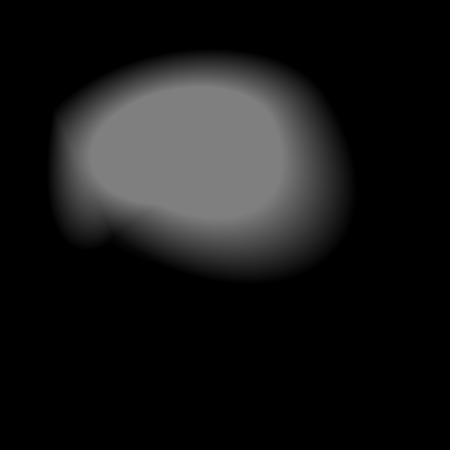

In [55]:
#display
pilTransformedMask = Image.fromarray(transformedMask)  
pilTransformedMask = pilTransformedMask.convert("L")
pilTransformedMask

#### grasp the size and center of the transformed mask

In [37]:
x = min(np.where(sum(transformedMask)>=1)[0])
xmax = max(np.where(sum(transformedMask)>=1)[0])
y = min(np.where(sum(transformedMask.T)>=1)[0])
ymax = max(np.where(sum(transformedMask.T)>=1)[0])

width = xmax-x
height= ymax-y

In [38]:
x,xmax,y,ymax,width,height

(65, 365, 38, 325, 300, 287)

#### generate fractal perlin noise

In [39]:
#np.random.seed()
noise = generate_fractal_noise_2d(shape=(shape, shape), res=(res, res), octaves=octaves, persistence=persistence, lacunarity=lacunarity)

#normalizing and scaling
noise = (noise+1)/2  #normalize between 0~1
resized_noise = resize(noise, (height + 1, width + 1))

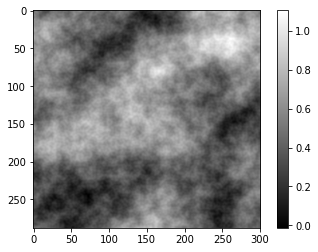

In [40]:
#display
plt.figure()
plt.imshow(resized_noise, cmap='gray', interpolation='lanczos')
plt.colorbar()
plt.show()

#### combine the mask with the perlin noise

In [41]:
pneumonia = resized_noise * normalizedTransformedMask[y:ymax+1, x:xmax+1]

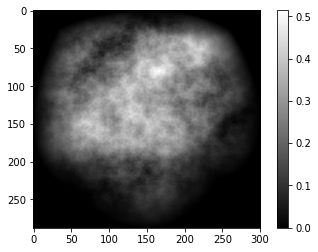

In [42]:
#display
plt.figure()
plt.imshow(pneumonia, cmap='gray', interpolation='lanczos')
plt.colorbar()
plt.show()

#### put the pseudo pneumonia on the lung image

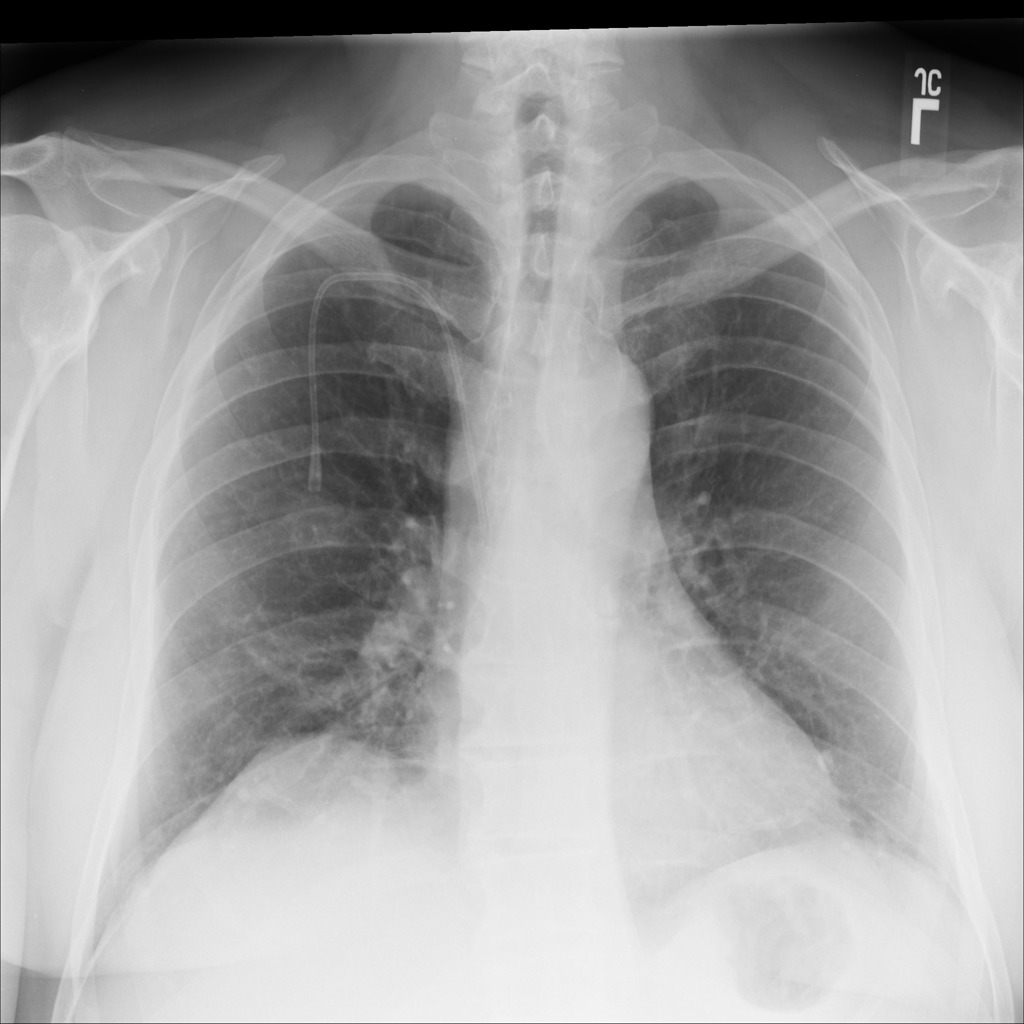

In [43]:
file_path = './data/sample2.png'  
img = Image.open(file_path)
img

In [44]:
centX, centY = 340, 500
newImg = img.copy()

for j in range(height):
    for i in range(width):
        x,y = int(centX-height//2+i), int(centY-width//2+j)
        inPixel = img.getpixel((x, y))
        pneumoniaPixel = pneumonia[j][i] 
        outPixel = inPixel * (1-pneumoniaPixel) + 255 * pneumoniaPixel
        newImg.putpixel((x, y), int(outPixel))

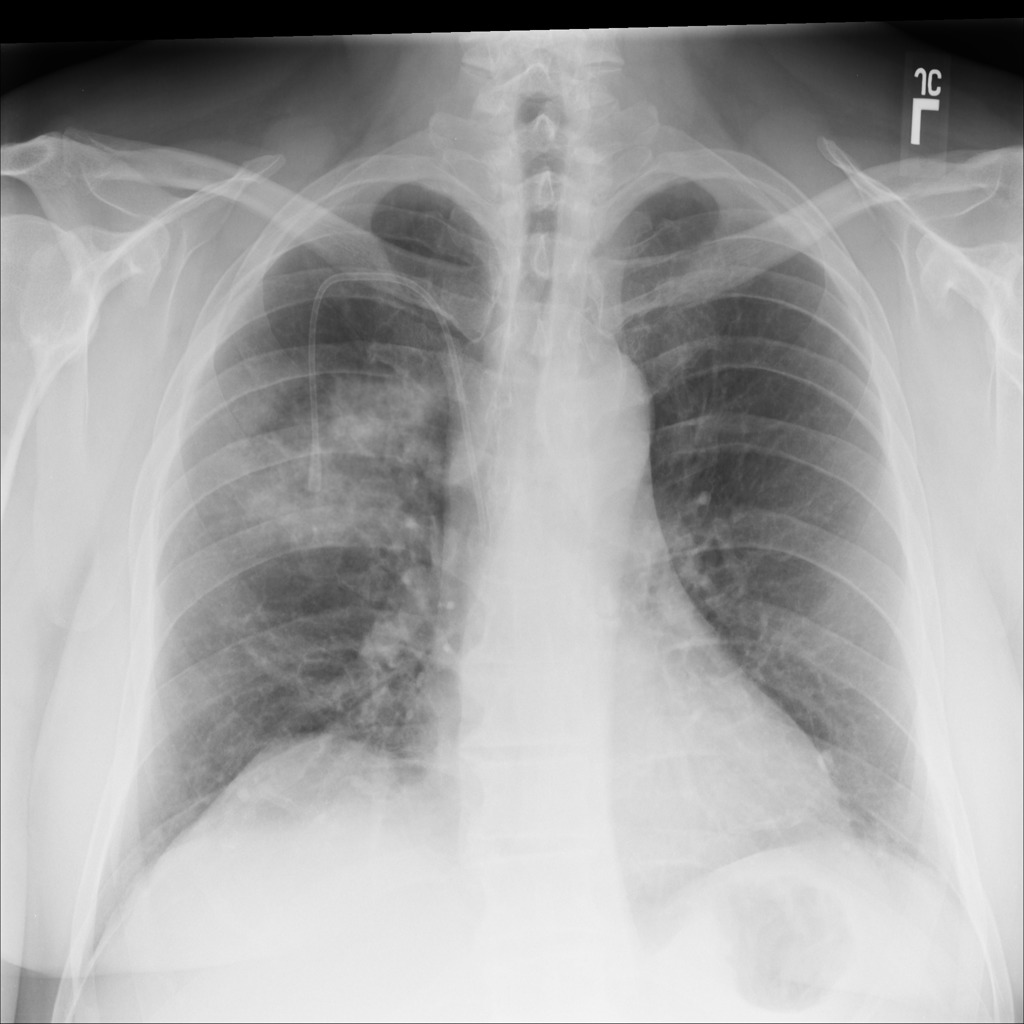

In [45]:
newImg